# Extended Research Project Model Development (svm)

## 1. Preprocess the data

In [1]:
# === Step 0: Import Libraries ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

C:\Users\teppe\anaconda3\envs\keras_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("Final_bayes_knn_ols_svm_svd.csv.gz", compression="gzip")

df

,net_income_usd,total_assets_usd,shareholders_funds_usd,capital_usd,revenue_usd,schooling_years_2020,urban_pop_growth_2022,logistics_index_2018,life_expectancy_2022,female_labor_participation_2023,...,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,svd_100
0,9.447491e+05,0.181549,NaN,-0.003279,3.541786e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.013482,-0.023297,-0.026130,-0.019788,0.008973,-0.005500,-0.019473,-0.009817,0.011526,-0.029350
1,1.765783e+04,0.181549,0.098608,0.040249,1.437969e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.012744,0.026045,0.019724,0.076969,0.012354,-0.062352,-0.000067,0.075836,-0.045383,0.066350
2,-2.502728e+04,0.181549,-0.168453,0.040249,1.246335e+06,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.006091,0.001558,-0.050122,0.024515,0.019798,-0.018739,-0.008884,-0.005824,0.011487,0.007655
3,1.023630e+03,0.181549,0.020692,0.028005,7.675140e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,-0.001193,-0.001749,0.001392,0.000009,-0.001890,-0.003163,-0.002057,-0.000404,0.000297,-0.000742
4,6.034728e+02,0.181549,0.013782,0.028005,7.037159e+05,1.186760,-1.189779,-0.492681,-0.677844,1.057754,...,0.000117,0.000087,0.000720,0.000368,-0.000447,0.000312,0.000811,0.000741,-0.000101,-0.000551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477072,-9.593861e+03,0.181549,0.188289,0.040249,-7.980458e+03,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,-0.005517,0.001996,0.077717,-0.047973,-0.012855,0.029138,-0.006654,0.009551,-0.004272,-0.026978
477073,-1.343988e+04,-0.028028,-0.004174,0.040249,-1.343954e+04,-2.574365,2.371344,-1.654855,-1.126116,-1.398460,...,-0.001345,0.001982,-0.014596,0.005058,0.005936,-0.001358,-0.003218,0.003140,0.005679,-0.002221
477074,-1.027999e+05,0.181549,0.126416,0.040249,-9.145863e+04,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,-0.001433,0.003882,0.002399,-0.002214,-0.000403,0.002592,-0.000637,0.000756,-0.001343,-0.000120
477075,-7.534849e+01,-0.024172,0.000283,0.000499,-9.680114e+05,-0.702729,0.619942,0.842805,0.877332,-0.384113,...,-0.003776,-0.006383,0.003070,0.000144,-0.000320,0.006390,0.004064,0.001612,-0.001478,0.002275


In [3]:
# create a df for classification
df_cls = df.copy()

# drop NaN
df_cls = df_cls.dropna()
df_cls.isna().sum().sum()

0

In [4]:
def create_success_flag(df):
    """
    Create a binary 'success' column based on revenue, net income, and cash flow thresholds.
    A company is considered successful if:
        - revenue_usd > 455.230 (top quartile)
        - net_income_usd > 0 (profitable)

    Parameters:
        df (pd.DataFrame): Input DataFrame containing startup financial data.

    Returns:
        df_new (pd.DataFrame): DataFrame with the added 'success' column.
        success_counts (pd.Series): Count of 0s and 1s in the 'success' column.
    """

    # Make a copy of the original DataFrame to preserve the input
    df_new = df.copy()

    # Define the success condition as a binary indicator
    # This checks whether all three conditions are met for each row
    df_new["success"] = (
        (df_new["revenue_usd"] > 455.230) &      # Top quartile of revenue
        (df_new["net_income_usd"] > 0)           # Positive net income
    ).astype(int)  # Convert boolean values to 0 or 1

    # Drop the columns used for creating the target to avoid data leakage
    df_new.drop(columns=["revenue_usd", "net_income_usd"], inplace=True)

    # Count how many startups are labeled as success (1) and not success (0)
    success_counts = df_new["success"].value_counts().sort_index()

    return df_new, success_counts

In [5]:
# create a df for classification
df_class, success_counts = create_success_flag(df_cls)
print(df_class["success"])
print(success_counts)

1         1
2         0
3         1
4         1
5         1
         ..
477072    0
477073    0
477074    0
477075    0
477076    0
Name: success, Length: 476920, dtype: int32
success
0    390252
1     86668
Name: count, dtype: int64


In [6]:
# CLASSIFICATION: Define target and feature columns
target_col_cls = "success"
feature_cols_cls = [col for col in df_class.columns if col != target_col_cls]

# Extract features and target
X_cls = df_class[feature_cols_cls].values
y_cls = df_class[target_col_cls].values

# Split into train, validation, and test sets (2D arrays only, no reshape)
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)
X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(X_temp_cls, y_temp_cls, test_size=0.5, random_state=42)

## 2. Define the svm model

In [7]:
'''
# === Step 2: Define svm Model for classification===
# CLASSIFICATION: Define svm model for Classification
class svmClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(svmClassifier, self).__init__()
        self.svm = nn.svm(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.svm(x)             # svm output
        out = out[:, -1, :]               # Use only last time step
        out = self.fc(out)                # Final classification layer
        return out
'''

'\n# === Step 2: Define svm Model for classification===\n# CLASSIFICATION: Define svm model for Classification\nclass svmClassifier(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):\n        super(svmClassifier, self).__init__()\n        self.svm = nn.svm(input_size, hidden_size, num_layers,\n                            batch_first=True, dropout=dropout)\n        self.fc = nn.Linear(hidden_size, num_classes)\n\n    def forward(self, x):\n        out, _ = self.svm(x)             # svm output\n        out = out[:, -1, :]               # Use only last time step\n        out = self.fc(out)                # Final classification layer\n        return out\n'

## 3. Tune hyperparameters by Optuna

In [8]:
# === Step 3: Optuna Hyperparameter Tuning for SVM Classification ===
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
def objective_sgd_cls(trial):
    # Define hyperparameter search space
    alpha = trial.suggest_loguniform("alpha", 1e-6, 1e-1)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
    loss = trial.suggest_categorical("loss", ["hinge", "log_loss"])  # hinge = SVM, log_loss = logistic regression

    # Use a subset of the training data for tuning
    sample_idx = np.random.choice(len(X_train_cls), size=2000, replace=False)
    X_tune = X_train_cls[sample_idx]
    y_tune = y_train_cls[sample_idx]

    # Create base model
    base_model = SGDClassifier(
        loss=loss,
        penalty=penalty,
        alpha=alpha,
        max_iter=1000,
        random_state=42
    )

    # Calibrate for probability output
    model = CalibratedClassifierCV(base_model, cv=3)

    # Fit and evaluate
    model.fit(X_tune, y_tune)
    y_pred = model.predict(X_val_cls)

    # Use weighted F1 score as objective
    return 1 - f1_score(y_val_cls, y_pred, average="weighted")

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective_sgd_cls, n_trials=20)

# Output best parameters
best_params_cls = study.best_trial.params
print("Best hyperparameters:", best_params_cls)

[I 2025-07-26 15:51:08,605] A new study created in memory with name: no-name-6686ac69-865a-4a74-a446-e2700cd9378d
C:\Users\teppe\AppData\Local\Temp\ipykernel_12420\1468185926.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-6, 1e-1)
[I 2025-07-26 15:51:10,796] Trial 0 finished with value: 0.2584585229866394 and parameters: {'alpha': 0.006307048148097139, 'penalty': 'l2', 'loss': 'hinge'}. Best is trial 0 with value: 0.2584585229866394.
C:\Users\teppe\AppData\Local\Temp\ipykernel_12420\1468185926.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-6, 1e-1)
[I 2025-07-26 15:51:12,

Best hyperparameters: {'alpha': 1.1059828374055818e-06, 'penalty': 'l2', 'loss': 'hinge'}


## 4. Re-learn with the optimized parameters

In [17]:
# === Step 4: Train Final Model with Best Params (Classification) ===
# Create base model using best hyperparameters
base_model = SGDClassifier(
    loss=best_params_cls['loss'],
    penalty=best_params_cls['penalty'],
    alpha=best_params_cls['alpha'],
    max_iter=1000,
    random_state=42
)

# Calibrate to enable probability prediction
svm_model_cls = CalibratedClassifierCV(base_model, cv=3)

# Fit to the full training data
svm_model_cls.fit(X_train_cls, y_train_cls)

# Predict class probabilities on validation set
#y_proba_val = svm_model_cls.predict_proba(X_val_cls)
y_pred_labels = svm_model_cls.predict(X_val_cls)

# Extract probabilities for each class
prob_0 = y_proba_val[:, 0]  # P(class = 0)
prob_1 = y_proba_val[:, 1]  # P(class = 1)


In [18]:
'''
import shap
# === Ensure input data is 2D ===
X_train_flat = X_train_cls.reshape(X_train_cls.shape[0], -1)
X_val_flat = X_val_cls.reshape(X_val_cls.shape[0], -1)

# === Define prediction function for SVM classifier ===
def model_predict_svm_classifier(X_numpy):
    # SVC must be trained with probability=True for this to work
    return svm_model_cls.predict_proba(X_numpy)[:, 1]  # Probability for class 1

# === Select background and explanation data ===
background_data = X_train_flat[:100]
explanation_data = X_val_flat[:50]

# === Initialize SHAP KernelExplainer (for black-box models like SVC) ===
explainer = shap.KernelExplainer(model_predict_svm_classifier, background_data)

# === Compute SHAP values (list of arrays: one per class) ===
shap_values = explainer.shap_values(explanation_data)

# === Extract class 1 SHAP values, convert to DataFrame, and save ===
feature_names = feature_cols_cls if 'feature_cols_cls' in locals() else [f"f{i}" for i in range(X_train_flat.shape[1])]
shap_df = pd.DataFrame(shap_values, columns=feature_names)
shap_df.to_csv("shap_values_svm_cls.csv", index=False)

# === Generate SHAP summary plot for class 1 ===
shap.summary_plot(shap_values, explanation_data, feature_names=feature_names)
'''

'\nimport shap\n# === Ensure input data is 2D ===\nX_train_flat = X_train_cls.reshape(X_train_cls.shape[0], -1)\nX_val_flat = X_val_cls.reshape(X_val_cls.shape[0], -1)\n\n# === Define prediction function for SVM classifier ===\ndef model_predict_svm_classifier(X_numpy):\n    # SVC must be trained with probability=True for this to work\n    return svm_model_cls.predict_proba(X_numpy)[:, 1]  # Probability for class 1\n\n# === Select background and explanation data ===\nbackground_data = X_train_flat[:100]\nexplanation_data = X_val_flat[:50]\n\n# === Initialize SHAP KernelExplainer (for black-box models like SVC) ===\nexplainer = shap.KernelExplainer(model_predict_svm_classifier, background_data)\n\n# === Compute SHAP values (list of arrays: one per class) ===\nshap_values = explainer.shap_values(explanation_data)\n\n# === Extract class 1 SHAP values, convert to DataFrame, and save ===\nfeature_names = feature_cols_cls if \'feature_cols_cls\' in locals() else [f"f{i}" for i in range(X_tra

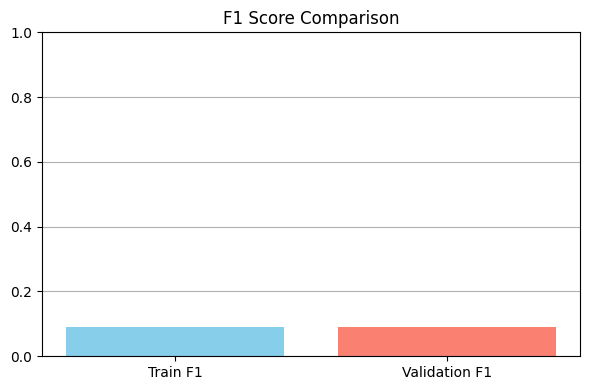

In [19]:
y_pred_train = svm_model_cls.predict(X_train_cls)
y_pred_val = svm_model_cls.predict(X_val_cls)

train_f1 = f1_score(y_train_cls, y_pred_train)
val_f1 = f1_score(y_val_cls, y_pred_val)

plt.figure(figsize=(6,4))
plt.bar(["Train F1", "Validation F1"], [train_f1, val_f1], color=["skyblue", "salmon"])
plt.title("F1 Score Comparison")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

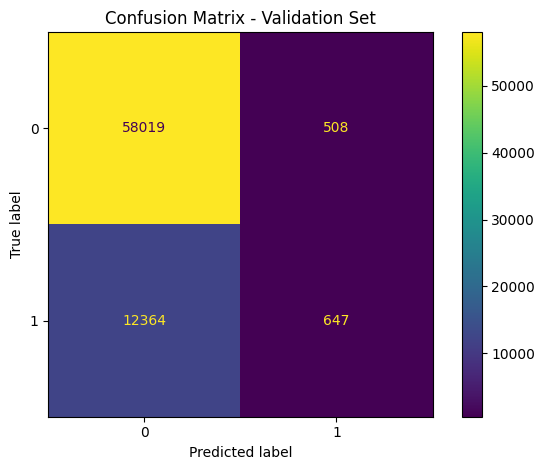

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_val_cls, y_pred_val)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

In [21]:
# Combine true and predicted labels with predicted probabilities
results_cls_df = pd.DataFrame({
    "true_label": y_val_cls,
    "predicted_label": y_pred_labels,
    "probability_0": prob_0,   # Probability for class 0
    "probability_1": prob_1    # Probability for class 1
})

# Save to CSV without index
results_cls_df.to_csv("classification_results.csv", index=False)

# Preview
results_cls_df.head()

,true_label,predicted_label,probability_0,probability_1
0,0,0,0.768559,0.231441
1,0,0,0.998186,0.001814
2,0,0,0.586958,0.413042
3,0,0,0.754468,0.245532
4,0,0,0.998057,0.001943


## 5. Evaluate the model


--- Evaluation on Training Data ---
AUC-ROC:     0.7993
F1-Score:    0.2607
Precision:   0.5732
Recall:      0.1687
Confusion Matrix:
[[265510   7627]
 [ 50465  10242]]
Mean G-Mean: 0.4050


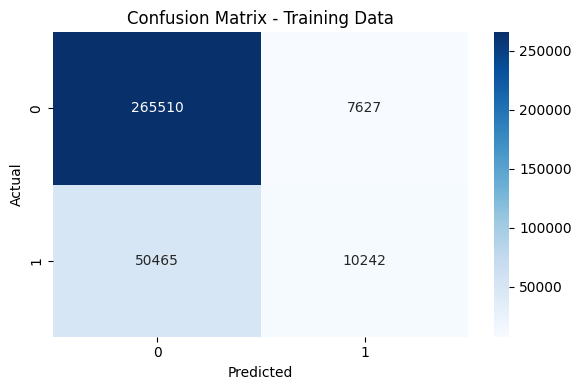


--- Evaluation on Validation Data ---
AUC-ROC:     0.7983
F1-Score:    0.2610
Precision:   0.5685
Recall:      0.1694
Confusion Matrix:
[[56854  1673]
 [10807  2204]]
Mean G-Mean: 0.4057


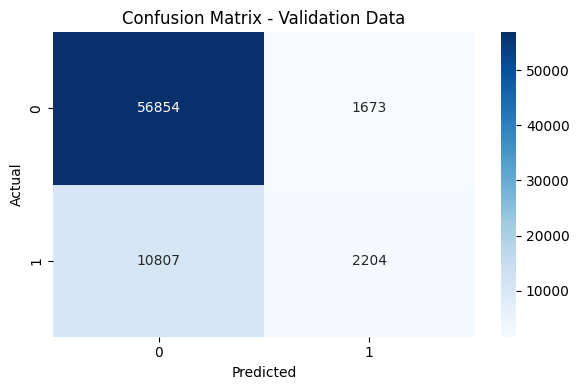


--- Evaluation on Test Data ---
AUC-ROC:     0.7991
F1-Score:    0.2721
Precision:   0.5839
Recall:      0.1774
Confusion Matrix:
[[56951  1637]
 [10653  2297]]
Mean G-Mean: 0.4152


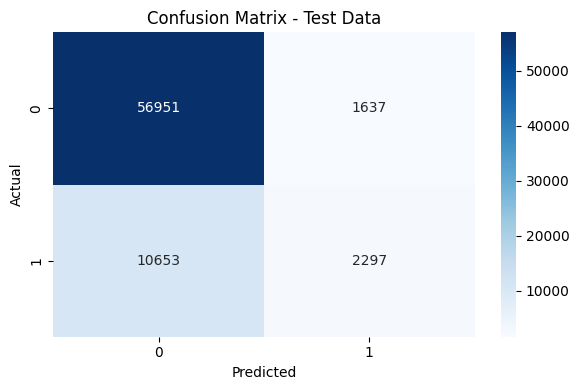

In [23]:
def evaluate_svm_classifier(model, X, y, dataset_name="", threshold=0.3):
    """
    Evaluate a trained svm classifier on given dataset.
    """
    # Predict probabilities and class labels
    prob = model.predict_proba(X)[:, 1]  # Probability of class 1
    preds = (prob > threshold).astype(int)     # Apply threshold

    # Metrics
    auc = roc_auc_score(y, prob)
    f1 = f1_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    conf_matrix = confusion_matrix(y, preds)

    # G-Mean
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn + 1e-6)
    tnr = tn / (tn + fp + 1e-6)
    gmean = np.sqrt(tpr * tnr)

    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Mean G-Mean: {gmean:.4f}")

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

evaluate_svm_classifier(svm_model_cls, X_train_cls, y_train_cls, "Training Data")
evaluate_svm_classifier(svm_model_cls, X_val_cls, y_val_cls, "Validation Data")
evaluate_svm_classifier(svm_model_cls, X_test_cls, y_test_cls, "Test Data")


--- Evaluation on Test Data @ 0.3 ---
AUC-ROC:     0.7991
F1-Score:    0.2721
Precision:   0.5839
Recall:      0.1774
Confusion Matrix:
[[56951  1637]
 [10653  2297]]
Mean G-Mean: 0.4152


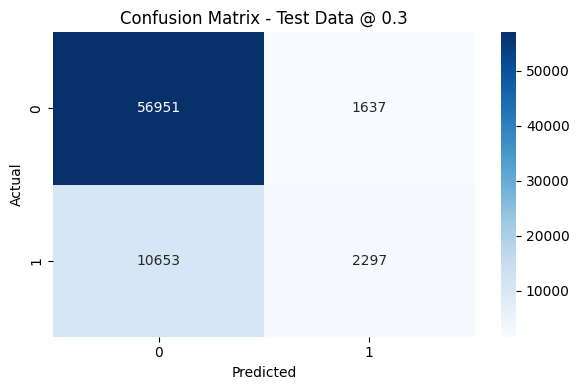


--- Evaluation on Test Data @ 0.1 ---
AUC-ROC:     0.7991
F1-Score:    0.0878
Precision:   0.5698
Recall:      0.0476
Confusion Matrix:
[[58123   465]
 [12334   616]]
Mean G-Mean: 0.2172


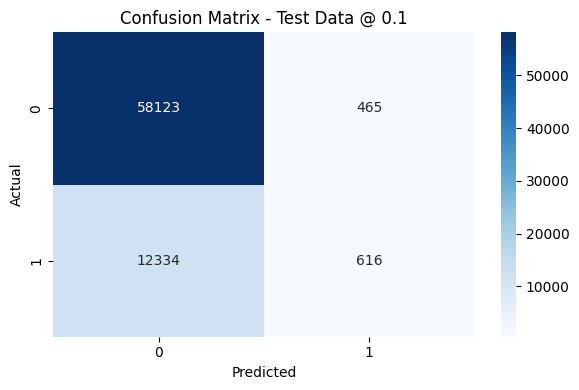


--- Evaluation on Test Data @ 0.5 ---
AUC-ROC:     0.7991
F1-Score:    0.4036
Precision:   0.2528
Recall:      0.9999
Confusion Matrix:
[[20324 38264]
 [    1 12949]]
Mean G-Mean: 0.5890


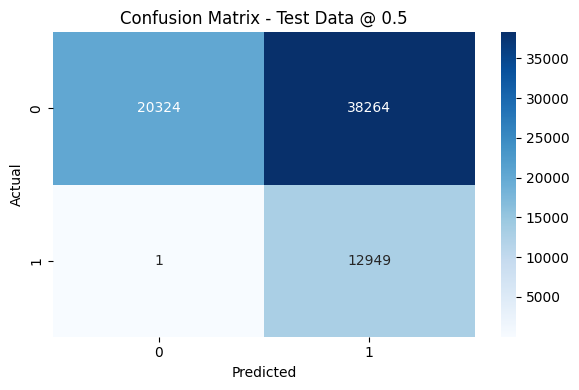

In [25]:
evaluate_svm_classifier(svm_model_cls, X_test_cls, y_test_cls, "Test Data @ 0.3", threshold=0.3)
evaluate_svm_classifier(svm_model_cls, X_test_cls, y_test_cls, "Test Data @ 0.1", threshold=0.5)
evaluate_svm_classifier(svm_model_cls, X_test_cls, y_test_cls, "Test Data @ 0.5", threshold=0.1)

## 6. Save the model

In [26]:
import joblib
import pandas as pd

# Save trained svm model
joblib.dump(svm_model_cls, "svm_cls_model.pkl")

# Save best hyperparameters as CSV
params_df = pd.DataFrame([best_params_cls])
params_df.to_csv("best_params_cls.csv", index=False)

# Save StandardScaler
#joblib.dump(scaler, "scaler.pkl")

## Optional: load the model

In [ ]:
'''
import joblib

# Load best hyperparameters from CSV
loaded_params_df = pd.read_csv("best_params_cls.csv")
best_params_cls = loaded_params_df.iloc[0].to_dict()

# Convert integer-like float values to int
best_params_cls['n_neighbors'] = int(best_params_cls['n_neighbors'])
best_params_cls['p'] = int(best_params_cls['p'])

# Load trained svm model
final_model = joblib.load("svm_model.pkl")

# Load scaler
#scaler = joblib.load("scaler.pkl")
'''